In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

1.15.0


In [2]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_data()

y = 1


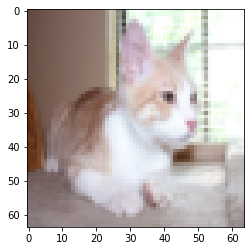

In [4]:
index = 4
plt.imshow(X_test_orig[index])
print ("y = " + str(np.squeeze(Y_test_orig[:, index])))

In [5]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T
print ("number of training examples =" + str(X_train.shape[0]))
print ("number of test examples =" + str(X_test.shape[0]))
print ("X_train shape = " + str(X_train.shape))
print ("Y_train shape = " + str(Y_train.shape))
print ("X_test shape = " + str(X_test.shape))
print ("Y_test shape = " + str(Y_test.shape))

number of training examples =209
number of test examples =50
X_train shape =(209, 64, 64, 3)
Y_train shape =(209, 1)
X_test shape =(50, 64, 64, 3)
Y_test shape =(50, 1)


In [6]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

In [7]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer())
    
    parameters = {"W1": W1,
                 "W2": W2}
    
    return parameters

In [8]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # Layer 1: CONV
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    
    # Layer 2: CONV
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    F = tf.contrib.layers.flatten(P2)
    
    # Layer 2: FC
    Z3 = tf.contrib.layers.fully_connected(F, 1, activation_fn = None, reuse = None, scope = 'w')
    
    return Z3

In [9]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = tf.transpose(Z3), labels = tf.transpose(Y)))
    return cost

In [10]:
def random_mini_batches(X, Y, mini_batch_size):
      
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size) # number of mini batches of size mini_batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [17]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m/minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _,temp_cost = sess.run([optimizer,cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost/num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print("Cost after epoch %i: %f" %(epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
            
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.show
        
        with tf.variable_scope('w', reuse=True):
            w = tf.get_variable('weights')
            b = tf.get_variable('biases')
            parameters = sess.run(parameters)
            w = sess.run(w)
            b = sess.run(b)
        
        predict = tf.sigmoid(Z3) > 0.5
        train_predict = predict.eval({X: X_train})
        test_predict = predict.eval({X: X_test})
               
        train_accuracy = 1 - np.mean(np.abs(train_predict - Y_train))
        test_accuracy = 1 - np.mean(np.abs(test_predict - Y_test))
        
        print("train_accuracy:", train_accuracy)
        print("test_accuracy:", test_accuracy)
                                                    
        return w, b, parameters

Cost after epoch 0: 0.782938
Cost after epoch 5: 0.614351
Cost after epoch 10: 0.510437
Cost after epoch 15: 0.452948
Cost after epoch 20: 0.400344
Cost after epoch 25: 0.402899
Cost after epoch 30: 0.308859
Cost after epoch 35: 0.217609
Cost after epoch 40: 0.279075
Cost after epoch 45: 0.280142
Cost after epoch 50: 0.143847
Cost after epoch 55: 0.133167
Cost after epoch 60: 0.193385
Cost after epoch 65: 0.070498
Cost after epoch 70: 0.048288
Cost after epoch 75: 0.059211
Cost after epoch 80: 0.028763
Cost after epoch 85: 0.020146
Cost after epoch 90: 0.023756
Cost after epoch 95: 0.011283
train_accuracy: 1.0
test_accuracy: 0.8200000000000001


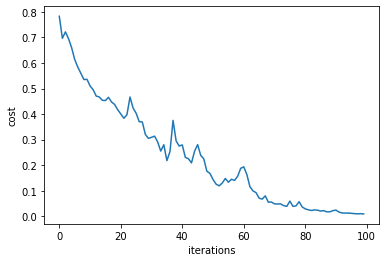

In [18]:
w, b, parameters = model(X_train, Y_train, X_test, Y_test)

In [39]:
def predict(X, parameters, w, b):
    W1 = parameters['W1']
    W2 = parameters['W2']
    with tf.Session() as sess:
        Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
        A1 = tf.nn.relu(Z1)
        P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    
        Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
        A2 = tf.nn.relu(Z2)
        P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
        F = tf.contrib.layers.flatten(P2)
    
        Z3 = tf.add(tf.matmul(F,w), b)
    
        p = tf.sigmoid(Z3) > 0.5
        p = sess.run(p)
    
        return p

-This is a cat? -True


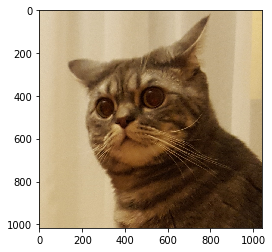

In [43]:
from PIL import Image

image = Image.open(r"images/my_image_3.jpg")
my_image = image.resize((64,64))
my_image = np.array(my_image)
my_image = my_image/255.
my_image = np.expand_dims(my_image, axis = 0)
m = tf.cast(my_image, tf.float32)

my_image_prediction = predict(m, parameters, w, b)
plt.imshow(image)
print("-This is a cat? -" + str(np.squeeze(my_image_prediction)))